## Pima Indian diabetes dataset

In [2]:
library(MASS)

In [3]:
nrow(Pima.tr)

[1] 200

In [4]:
nrow(Pima.te)

[1] 332

In [5]:
head(Pima.tr)

npreg,glu,bp,skin,bmi,ped,age,type
5,86,68,28,30.2,0.364,24,No
7,195,70,33,25.1,0.163,55,Yes
5,77,82,41,35.8,0.156,35,No
0,165,76,43,47.9,0.259,26,No
0,107,60,25,26.4,0.133,23,No
5,97,76,27,35.6,0.378,52,Yes


In [6]:
Pima.te$npreg = Pima.te$npreg > 3

In [7]:
Pima.tr$npreg = Pima.tr$npreg > 3

In [8]:
library("DALEX")
library("randomForest")
library("ceterisParibus")
set.seed(59)

# set default theme
theme_set(theme_bw() + theme(text = element_text(size = 18)))

Welcome to DALEX (version: 0.2.3).
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin

Loading required package: gower


In [9]:
table(Pima.tr$type)


 No Yes 
132  68 

In [10]:
table(Pima.te$type)


 No Yes 
223 109 

In [11]:
pima_rf_model <- randomForest(type~., data = Pima.tr)

In [12]:
pima_lm_model <- glm(type~., data=Pima.tr, family="binomial")

In [13]:
library("e1071")
pima_svm_model <- svm(type~., data=Pima.tr, probability = TRUE)

In [14]:
pred2 <- function(m, x)   predict(m, x, type = "prob")[,2]
pred_svm_2 <- function(m, x) attr(predict(m, x, probability = TRUE), "probabilities")[,2]

Model accuracies

In [15]:
pred_rf <- predict(pima_rf_model, Pima.te, type = "class")
pred_svm <- predict(pima_svm_model, Pima.te, type = "class")
pred_lm <- predict(pima_lm_model, Pima.te, type="response")
pred_lm <- pred_lm > 0.5
print(mean(pred_rf == Pima.te$type))
print(mean(pred_svm == Pima.te$type))
print(mean(pred_lm == (Pima.te$type == "Yes")))

[1] 0.7560241
[1] 0.7771084
[1] 0.7891566


In [59]:
explainer_rf_yes <- explain(pima_rf_model, data = Pima.te[,1:7], 
                              y = Pima.te$type == "Yes", 
                              predict_function = pred2, label = "rf")

explainer_svm_yes <- explain(pima_svm_model, data = Pima.te[,1:7], 
                              y = Pima.te$type == "Yes", 
                              predict_function = pred_svm_2, label = "svm")

In [60]:
pima_A <- select_neighbours(Pima.te, Pima.te[1,], n = 15)

In [61]:
cp_rf1 <- ceteris_paribus(explainer_rf_yes, pima_A)
cp_svm1 <- ceteris_paribus(explainer_svm_yes, pima_A)

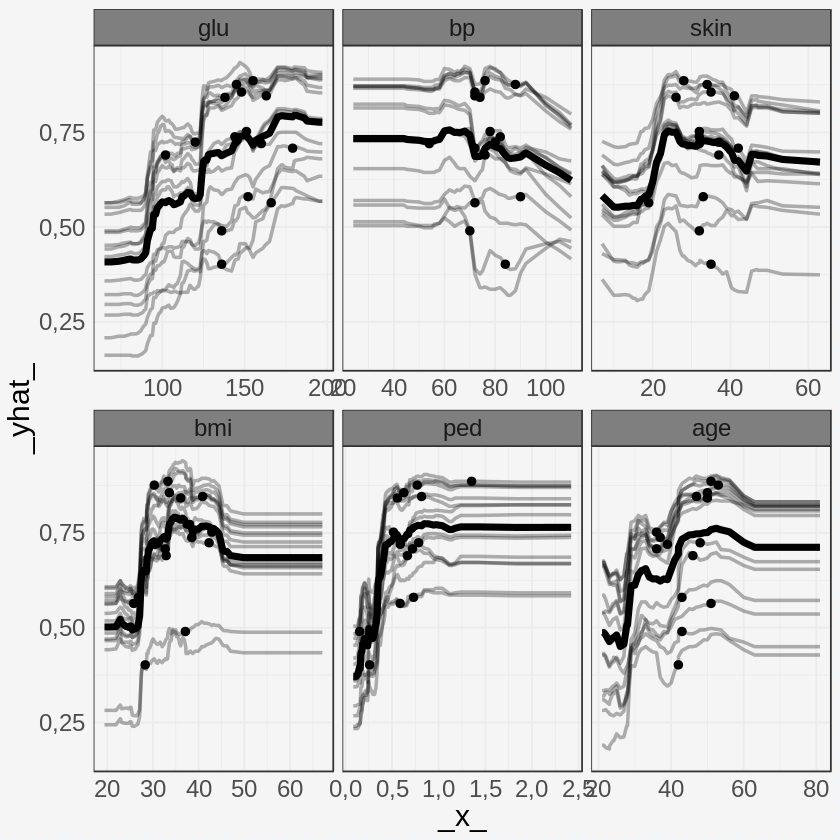

In [62]:
plot(cp_rf1) +
ceteris_paribus_layer(cp_rf1, 
            show_observations = FALSE, show_rugs = FALSE,
            aggregate_profiles = mean, size = 2, alpha = 1) 

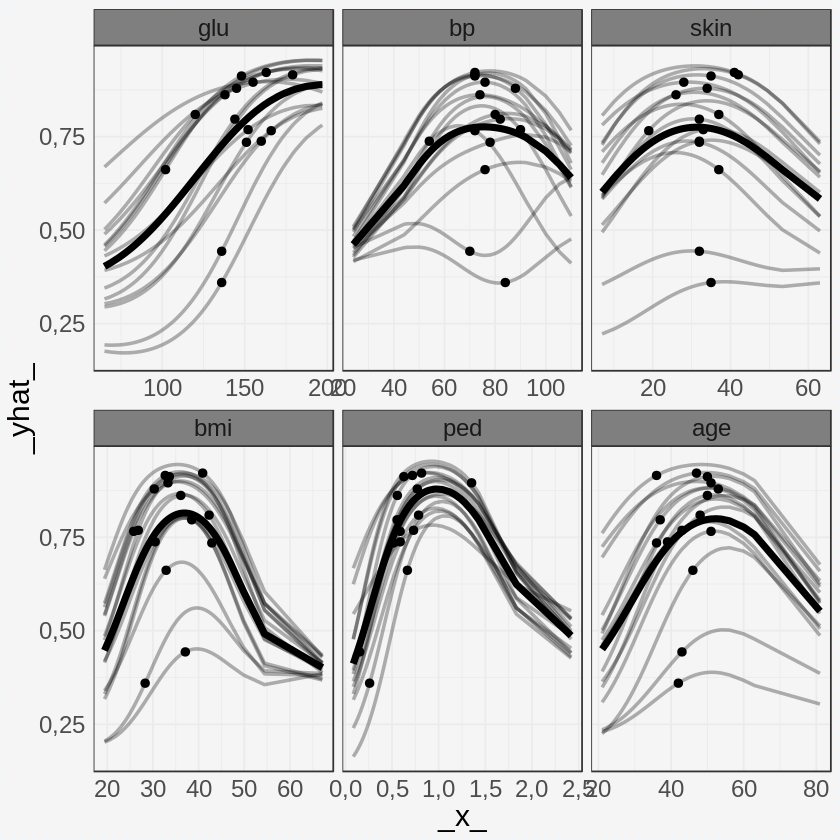

In [63]:
plot(cp_svm1) + 
ceteris_paribus_layer(cp_svm1, 
            show_observations = FALSE, show_rugs = FALSE,
            aggregate_profiles = mean, size = 2, alpha = 1) 

Compare classifiers, categorize by discrete value of birth rates

In [64]:
pima_B <- select_sample(Pima.te, n = 20, seed = 42)
cp_rf2 <- ceteris_paribus(explainer_rf_yes, pima_B)

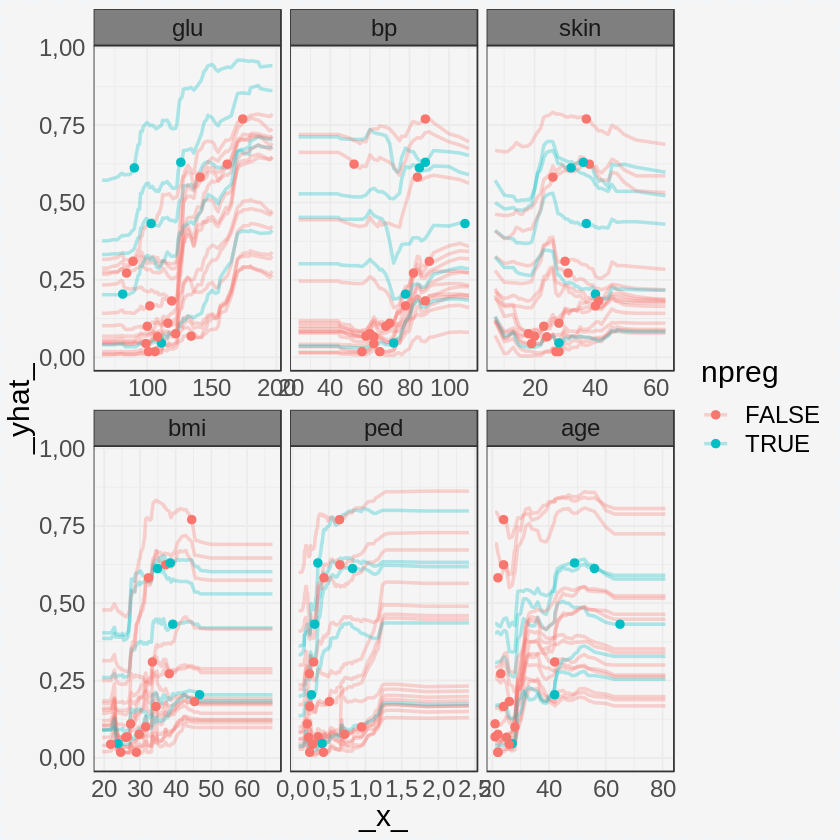

In [70]:
plot(cp_rf2, color="npreg")

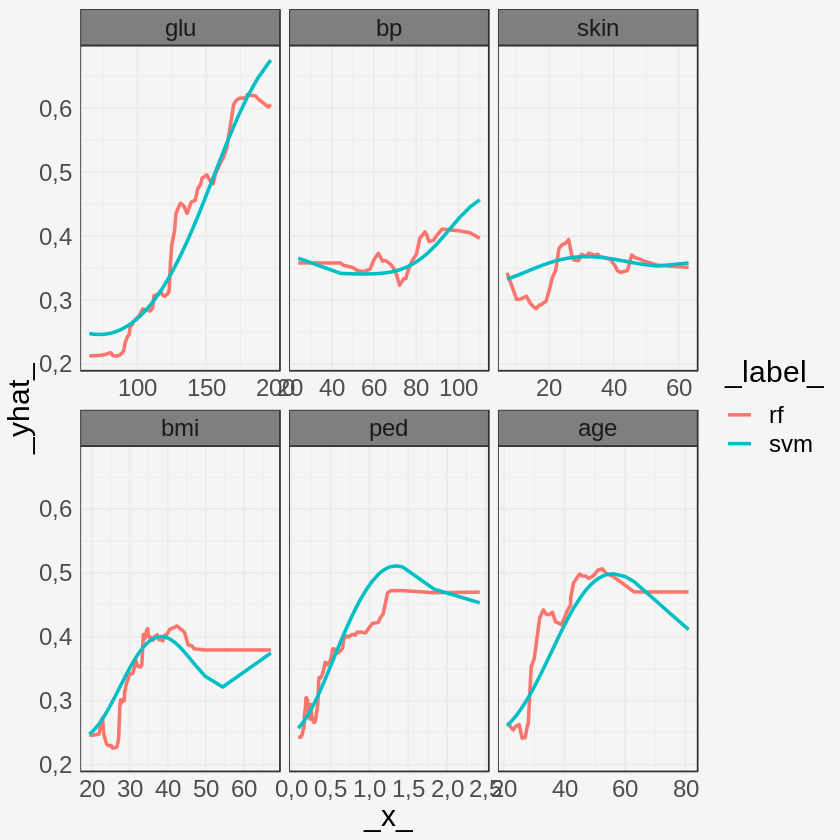

In [71]:
cp_rf3 <- ceteris_paribus(explainer_rf_yes, Pima.te[1:100,], y=Pima.te$type[1:100])
cp_svm3 <- ceteris_paribus(explainer_svm_yes, Pima.te[1:100,], y=Pima.te$type[1:100])

plot(cp_rf3, cp_svm3,
     color = "_label_", 
     aggregate_profiles = mean, 
     alpha = 1, show_observations = FALSE)

In [67]:
print(cp_rf3)

Top profiles    : 
    npreg glu bp skin  bmi   ped age type _yhat_ _vname_ _ids_ _label_
1    TRUE 148 72   35 33,6 0,627  50  Yes  0,856   npreg     1      rf
1.1 FALSE 148 72   35 33,6 0,627  50  Yes  0,826   npreg     1      rf
2    TRUE  85 66   29 26,6 0,351  31   No  0,146   npreg     2      rf
2.1 FALSE  85 66   29 26,6 0,351  31   No  0,140   npreg     2      rf
3    TRUE  89 66   23 28,1 0,167  21   No  0,042   npreg     3      rf
3.1 FALSE  89 66   23 28,1 0,167  21   No  0,042   npreg     3      rf


Top observations:
  npreg glu bp skin  bmi   ped age type _yhat_ _y_ _label_
1  TRUE 148 72   35 33,6 0,627  50  Yes  0,856 Yes      rf
2 FALSE  85 66   29 26,6 0,351  31   No  0,140  No      rf
3 FALSE  89 66   23 28,1 0,167  21   No  0,042  No      rf
4 FALSE  78 50   32 31,0 0,248  26  Yes  0,084 Yes      rf
5 FALSE 197 70   45 30,5 0,158  53  Yes  0,650 Yes      rf
6  TRUE 166 72   19 25,8 0,587  51  Yes  0,564 Yes      rf
